# Library

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf


# 한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='white')

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], 
#                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 시각화 함수 정의

In [2]:
# 0. 4069개 종류의 feature name 정보를 담은 dict 생성
feature_df = pd.read_csv('feature_df.csv')
feature_name = dict(zip(feature_df['feature'], feature_df['feature_name']))

X = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# 1. 사망 / 생존 환자 인덱스
d_index = np.where(y==1)[0]
s_index = np.where(y==0)[0]

# 2. 사망 / 생존 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []

for d in range(10):
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def absum(top10_list):
    plt.figure(figsize = (12,10), dpi=150)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(4,4,1+i)
        plt.title(feature_name[f])
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='생존', linestyle=':', marker='o')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

((40680, 3), (40680, 3))

# M2 역전성 - 사망 / 생존 마커 TOP10
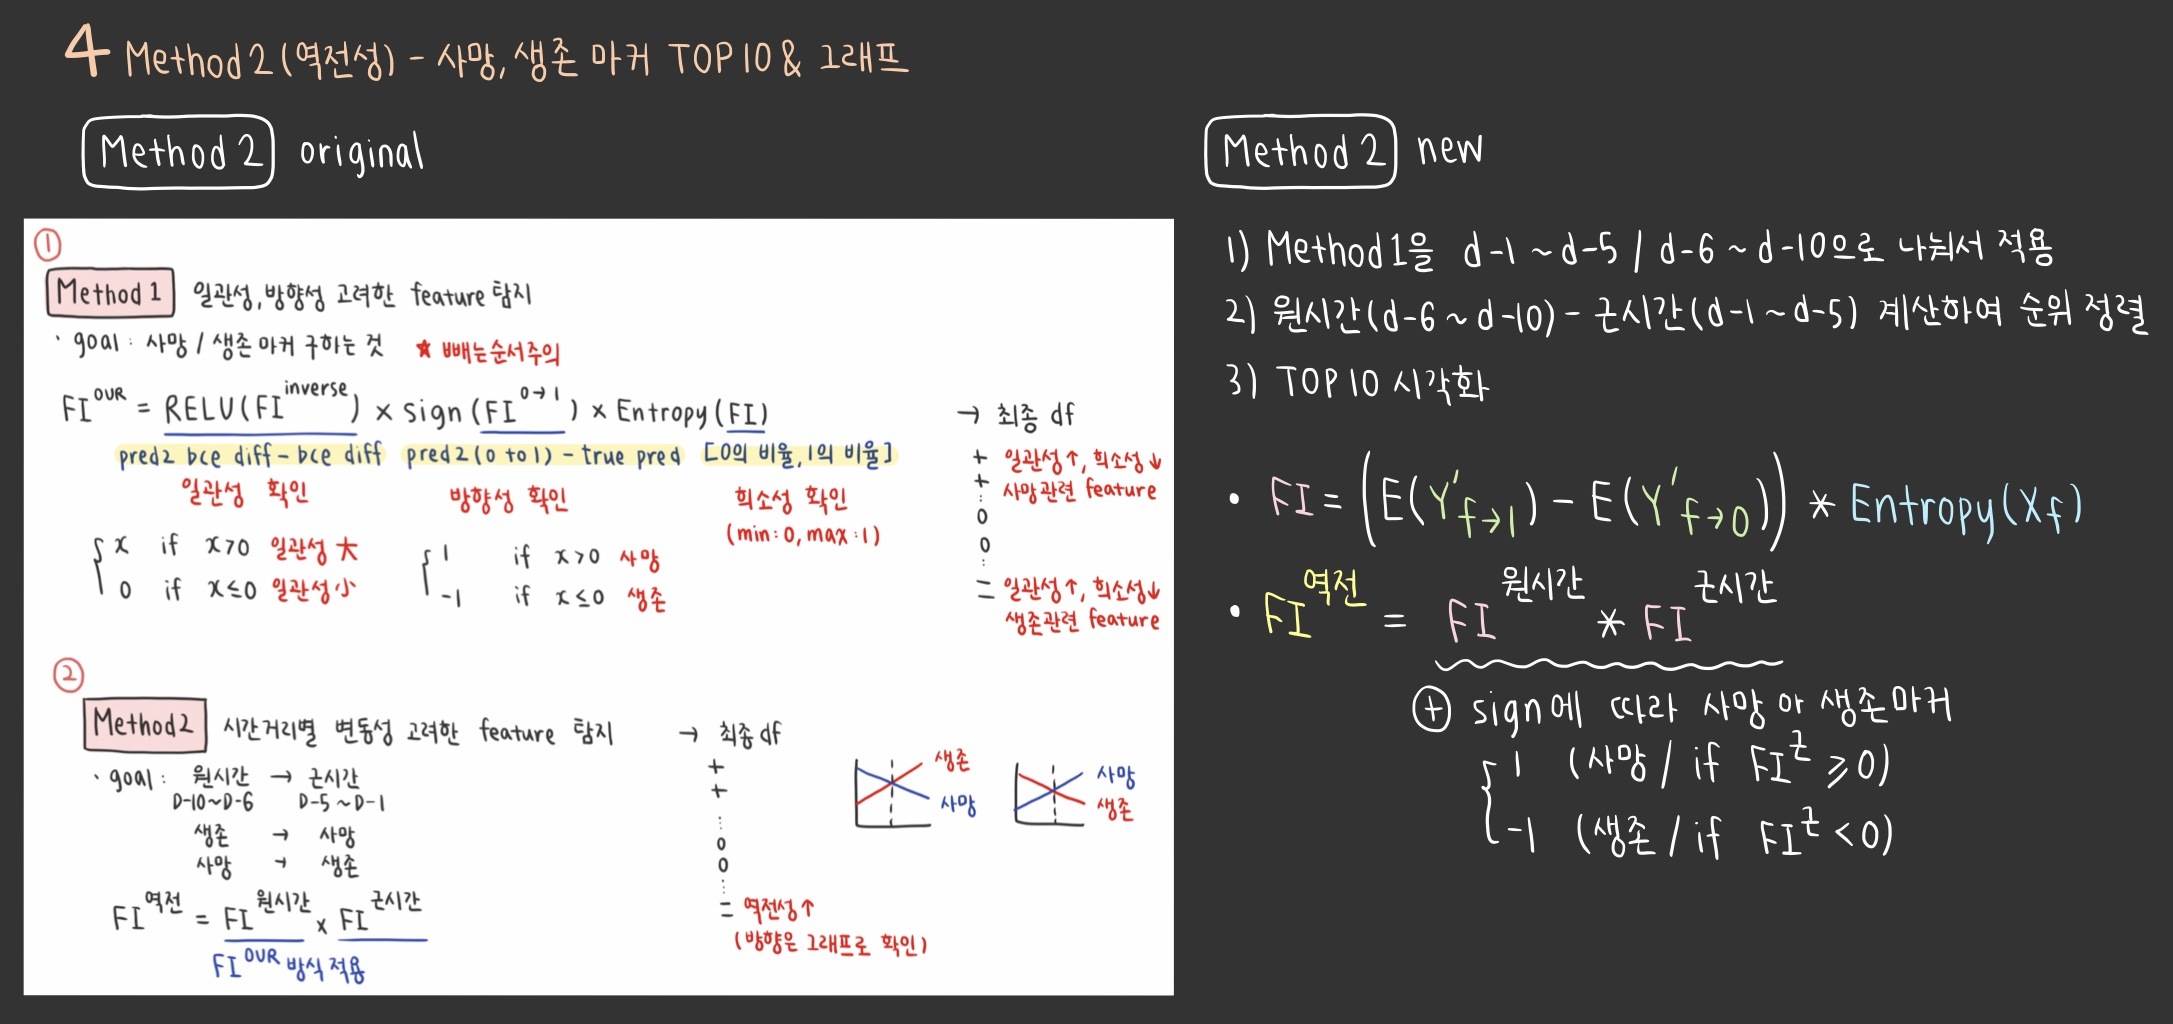

# M2_new

## x_(7727, 10, 3595)

In [5]:
# 1) DATA 
x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727_10_3595.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/f3595-06-val_loss:0.5522.hdf5') # 3595용 모델

results = []
with tf.device('/device:GPU:1'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) 원시간 : E(0to1) - E(1to0)
        x[:,:5,i] = 1
        원_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,:5,i] = 0
        원_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        # 4) 근시간 : E(0to1) - E(1to0)
        x[:,5:,i] = 1
        근_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,5:,i] = 0
        근_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        results.append({'feature':features[i], '원_mean_diff':원_mean_0to1-원_mean_1to0, '근_mean_diff':근_mean_0to1-근_mean_1to0})

  0%|          | 0/3595 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(results)
df.to_csv('m2_df_3595.csv', index = False)

In [7]:
# 1. Entropy 구하기 -> 'entropy_3595.csv'로 저장

from scipy.stats import entropy

x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data_7727_10_3595.csv')
features = list(a['ITEMID'].sort_values().unique()) # 3595개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)
entropy_df.to_csv('entropy_3595.csv', index = False)

  0%|          | 0/3595 [00:00<?, ?it/s]

In [15]:
# 2. FI^역전 score가 포함된 df 생성

df1 = pd.read_csv('m2_df_3595.csv')
en_df = pd.read_csv('entropy_3595.csv')

m2_3595_score = pd.merge(df1, en_df, on = 'feature')
m2_3595_score['FI_원거리'] = m2_3595_score['원_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['FI_근거리'] = m2_3595_score['근_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['Sign'] = m2_3595_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_3595_score['FI_역전성'] = m2_3595_score['FI_원거리'] * m2_3595_score['FI_근거리']

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
190,51277,0.022620,0.092133,0.919332,0.020796,0.084701,1,0.001761
110,51006,0.015648,0.071670,0.980942,0.015350,0.070304,1,0.001079
52,50912,0.012732,0.053038,0.848272,0.010800,0.044990,1,0.000486
38,50893,0.009052,0.043241,0.891332,0.008068,0.038542,1,0.000311
31,50882,0.009896,0.046454,0.767764,0.007598,0.035666,1,0.000271
1929,409176230,0.018425,0.100652,0.380630,0.007013,0.038311,1,0.000269
94,50983,0.010462,0.043576,0.561714,0.005876,0.024477,1,0.000144
108,51003,0.015296,0.071515,0.329998,0.005048,0.023600,1,0.000119
19,50862,0.008993,0.046459,0.470553,0.004232,0.021862,1,0.000093
903,54848616,0.010743,0.041319,0.435895,0.004683,0.018011,1,0.000084


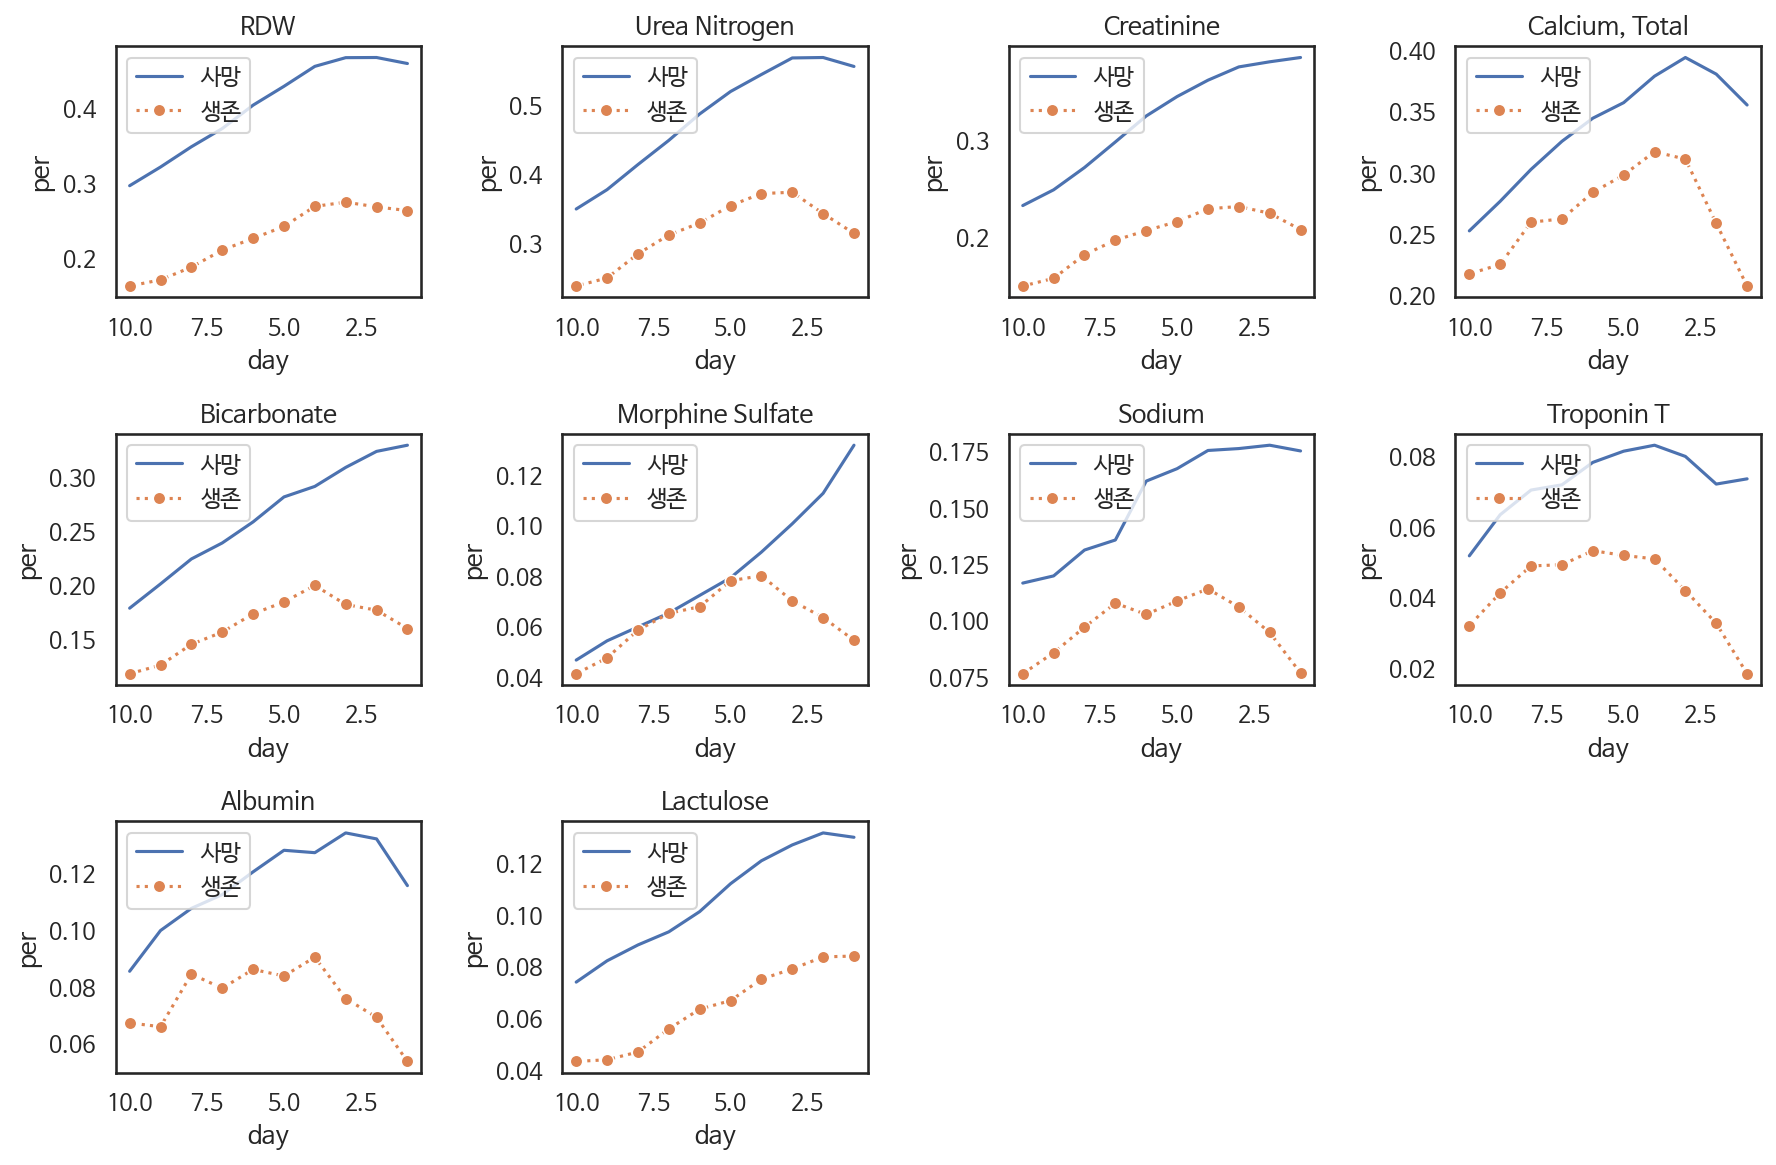

In [14]:
# 역전성 - 사망 마커 TOP10

m2_3595_사망 = m2_3595_score[m2_3595_score['Sign']==1].sort_values(by = 'FI_역전성', ascending = False)
m2_3595_사망[:10]
absum(m2_3595_사망[:10]['feature'])

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
2355,904516561,0.001385,-0.013199,0.735511,0.001019,-0.009708,-1,-9.892581e-06
2336,904224461,0.002230,-0.010638,0.557009,0.001242,-0.005926,-1,-7.360112e-06
2616,49502069724,0.002071,-0.003756,0.602292,0.001248,-0.002262,-1,-2.822607e-06
2104,536338101,0.002481,-0.005670,0.361956,0.000898,-0.002052,-1,-1.843066e-06
2423,8290036005,0.000358,-0.009244,0.490131,0.000176,-0.004531,-1,-7.959873e-07
1893,406055262,0.000982,-0.009814,0.267090,0.000262,-0.002621,-1,-6.875782e-07
3507,66553000401,0.000655,-0.005356,0.302693,0.000198,-0.001621,-1,-3.212563e-07
2720,51079004120,0.000467,-0.012905,0.223782,0.000105,-0.002888,-1,-3.020358e-07
932,56016975,0.001708,-0.003301,0.168746,0.000288,-0.000557,-1,-1.605315e-07
2347,904399061,0.004294,-0.000578,0.248676,0.001068,-0.000144,-1,-1.535050e-07


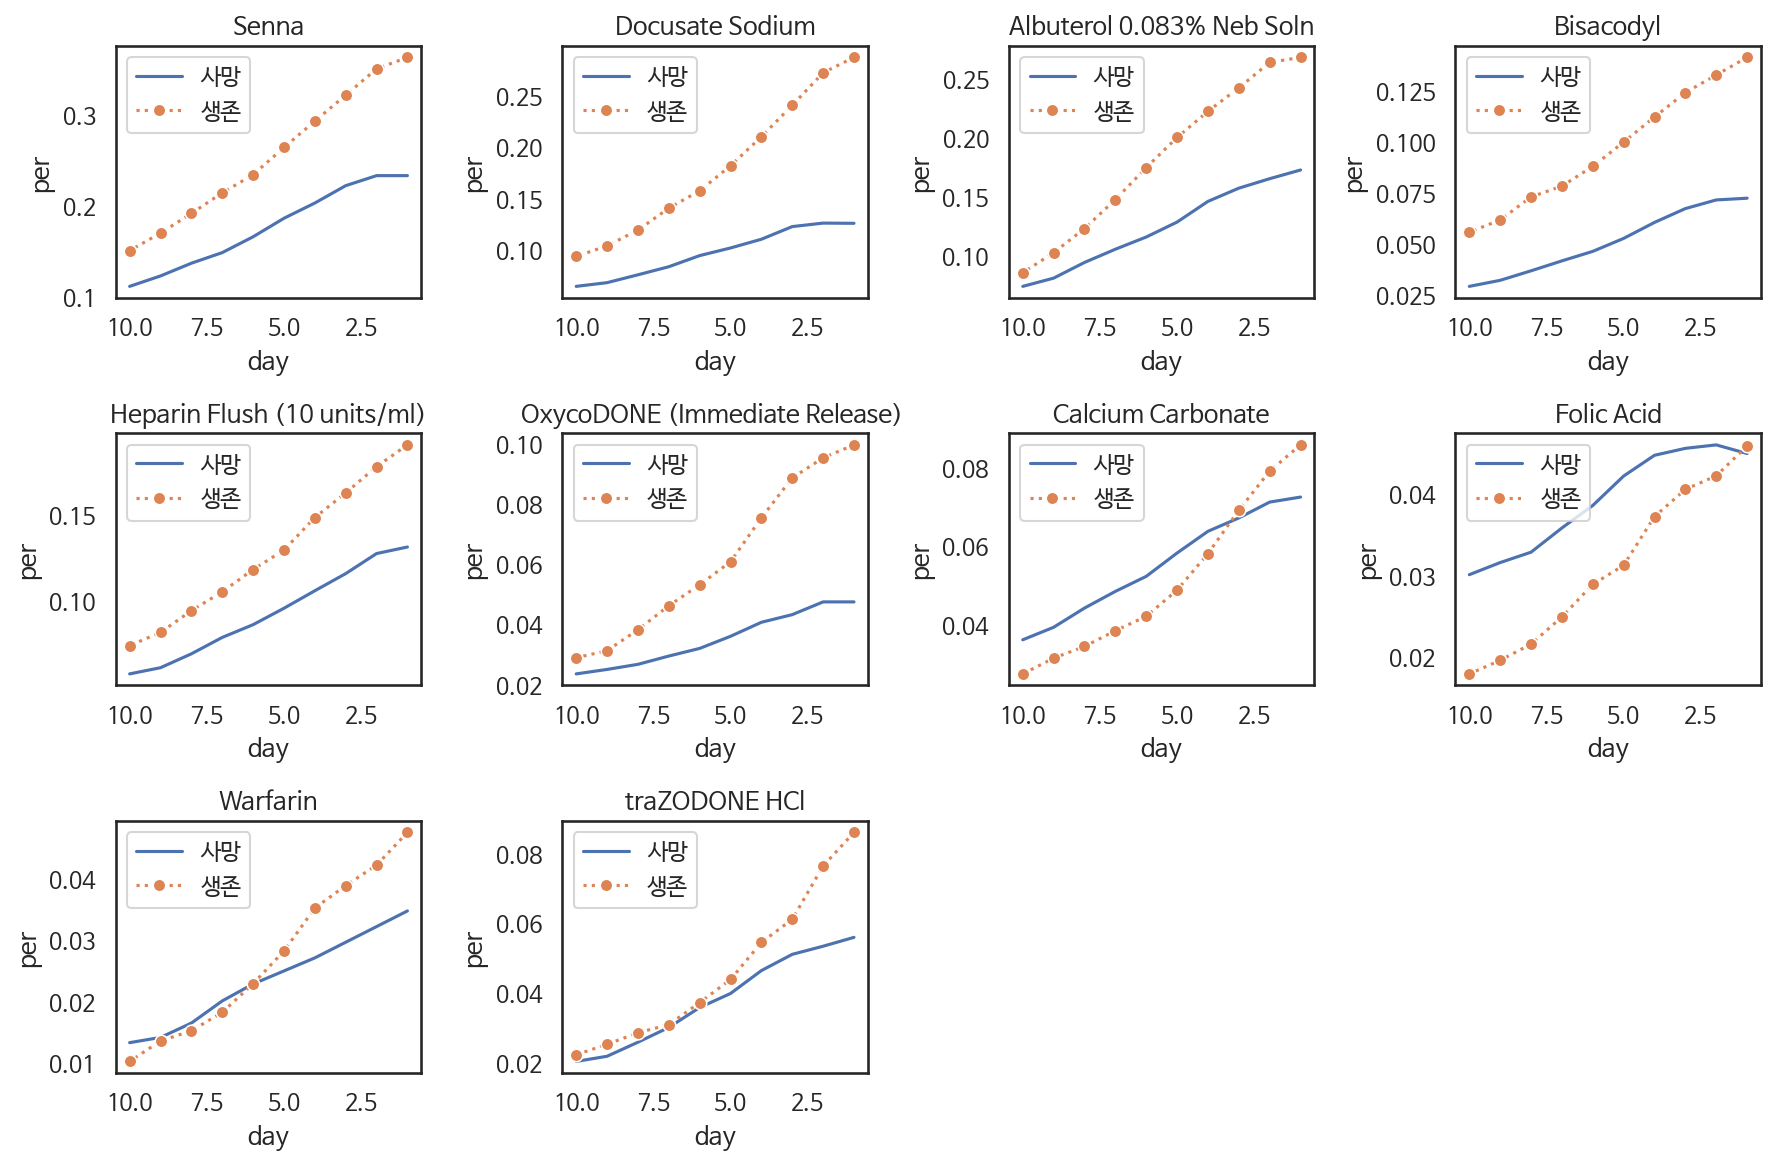

In [16]:
# 역전성 - 생존 마커 TOP10

m2_3595_생존 = m2_3595_score[m2_3595_score['Sign']==-1].sort_values(by = 'FI_역전성')
m2_3595_생존[:10]
absum(m2_3595_생존[:10]['feature'])

## x_(7727, 10, 4068)

In [ ]:
# 1) DATA 
x = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('/project/LSH/total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()
print(len(features))

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/seed42-06-val_loss:0.5523.hdf5') # 4068용 모델

results = []
with tf.device('/device:GPU:0'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) 원시간 : E(0to1) - E(1to0)
        x[:,:5,i] = 1
        원_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,:5,i] = 0
        원_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        # 4) 근시간 : E(0to1) - E(1to0)
        x[:,5:,i] = 1
        근_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,5:,i] = 0
        근_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        results.append({'feature':features[i], '원_mean_diff':원_mean_0to1-원_mean_1to0, '근_mean_diff':근_mean_0to1-근_mean_1to0})
        
df = pd.DataFrame(results)
df.to_csv('m2_df_4068.csv', index = False)

4068


Using TensorFlow backend.


  0%|          | 0/4068 [00:00<?, ?it/s]

In [ ]:
# 1. Entropy 구하기 -> 'entropy_4068.csv'로 저장

from scipy.stats import entropy

x = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)
entropy_df.to_csv('entropy_4068.csv', index = False)

In [ ]:
# 2. FI^역전 score가 포함된 df 생성

df1 = pd.read_csv('m2_df_4068.csv')
en_df = pd.read_csv('entropy_4068.csv')

m2_4068_score = pd.merge(df1, en_df, on = 'feature')
m2_4068_score['FI_원거리'] = m2_4068_score['원_mean_diff'] * m2_4068_score['entropy']
m2_4068_score['FI_근거리'] = m2_4068_score['근_mean_diff'] * m2_4068_score['entropy']
m2_4068_score['Sign'] = m2_4068_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_4068_score['FI_역전성'] = m2_4068_score['FI_원거리'] * m2_4068_score['FI_근거리']
m2_4068_score